In [15]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Extract garment mask for flat garments

In [16]:
def process_flat_garment(
    garment_image_path,
    num_classes=20,
    save_path=None
):
    """
    Handles flat garment (shop style).
    Uses rembg to generate mask.
    Returns:
        garment_rgb (H,W,3)
        garment_mask (H,W)
        source_parsing_tensor (C,H,W)
    """

    from rembg import remove

    # Load image
    garment_pil = Image.open(garment_image_path)
    garment_rgba = remove(garment_pil)

    rgba_np = np.array(garment_rgba)
    garment_rgb = rgba_np[:, :, :3]
    alpha = rgba_np[:, :, 3]

    garment_mask = alpha > 0

    H, W = garment_mask.shape

    # Build dummy parsing map:
    # All garment pixels assigned to class 5 (upper clothes)
    parsing = np.zeros((H, W), dtype=np.uint8)
    parsing[garment_mask] = 5

    # Build one-hot tensor
    source_parsing_tensor = torch.zeros(num_classes, H, W)
    for c in range(num_classes):
        source_parsing_tensor[c] = torch.from_numpy(
            (parsing == c).astype(float)
        )

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

        cv2.imwrite(
            os.path.join(save_path, "garment_mask.png"),
            garment_mask.astype(np.uint8) * 255
        )

        cv2.imwrite(
            os.path.join(save_path, "garment_rgb.png"),
            cv2.cvtColor(garment_rgb, cv2.COLOR_RGB2BGR)
        )

        torch.save(
            source_parsing_tensor,
            os.path.join(save_path, "source_parsing.pt")
        )

    return garment_rgb, garment_mask, source_parsing_tensor

Extract masks if target garment is worn by a person

In [23]:
def process_worn_garment(
    original_image_path,
    schp_mask_path,
    num_classes=20,
    save_path=None
):
    """
    Handles garment worn by a person.
    Requires original image + SCHP parsing mask.
    Returns:
        garment_rgb (H,W,3)
        garment_mask (H,W)
        source_parsing_tensor (C,H,W)
    """

    # Load original RGB image using PIL for robustness
    image_pil = Image.open(original_image_path).convert("RGB")
    image = np.array(image_pil)

    H, W = image.shape[:2]

    # Load SCHP parsing
    parsing = np.array(Image.open(schp_mask_path))

    # Garment classes in LIP
    GARMENT_CLASSES = [5, 6, 7, 10]

    garment_mask = np.isin(parsing, GARMENT_CLASSES)

    # Extract garment RGB using mask
    garment_rgb = image.copy()
    garment_rgb[~garment_mask] = 0

    # Build FEM-compatible one-hot parsing tensor
    source_parsing_tensor = torch.zeros(num_classes, H, W)
    for c in range(num_classes):
        source_parsing_tensor[c] = torch.from_numpy(
            (parsing == c).astype(float)
        )

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

        cv2.imwrite(
            os.path.join(save_path, "garment_mask.png"),
            garment_mask.astype(np.uint8) * 255
        )

        cv2.imwrite(
            os.path.join(save_path, "garment_rgb.png"),
            cv2.cvtColor(garment_rgb, cv2.COLOR_RGB2BGR)
        )

        torch.save(
            source_parsing_tensor,
            os.path.join(save_path, "source_parsing.pt")
        )

    return garment_rgb, garment_mask, source_parsing_tensor

Process flat garment

In [19]:
rgb, mask, tensor = process_flat_garment(
    garment_image_path="/content/Inputs/flat.jpg",
    save_path="/content/Outputs/flat_garment"
)

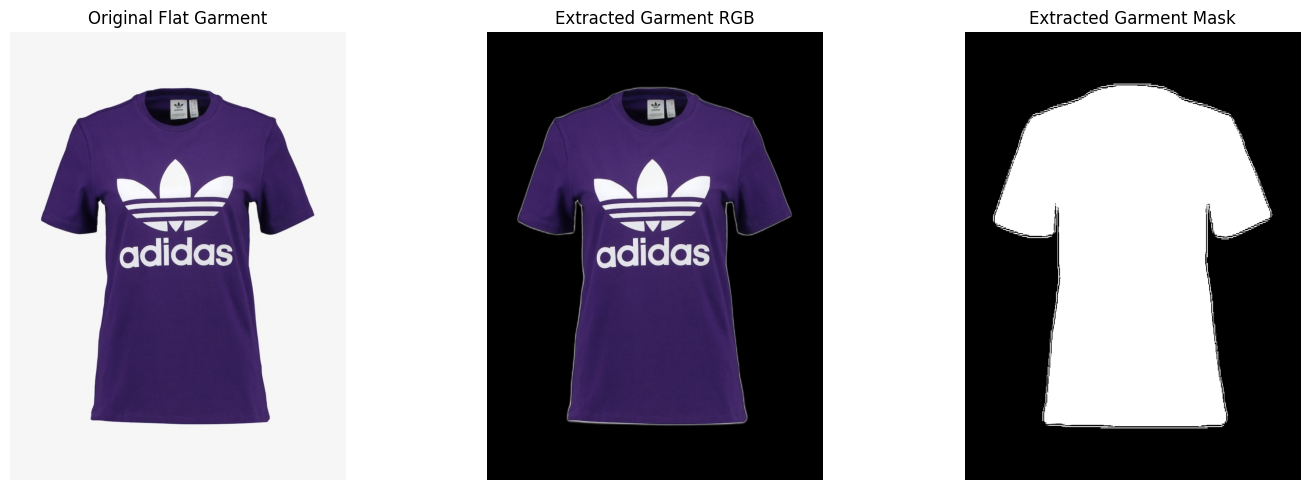

In [26]:
input_image_path = "/content/Inputs/flat.jpg"
output_dir = "/content/Outputs/flat_garment"

# Load original input image
original_garment = Image.open(input_image_path)

# Load processed garment RGB and mask
processed_garment_rgb = Image.open(os.path.join(output_dir, "garment_rgb.png"))
processed_garment_mask = Image.open(os.path.join(output_dir, "garment_mask.png"))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_garment)
plt.title("Original Flat Garment")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(processed_garment_rgb)
plt.title("Extracted Garment RGB")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(processed_garment_mask, cmap='gray')
plt.title("Extracted Garment Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

Process worn garment

In [25]:
rgb, mask, tensor = process_worn_garment(
    original_image_path="/content/Inputs/target-person.jpg",
    schp_mask_path="/content/Inputs/target.png",
    save_path="/content/Outputs/worn_garment"
)

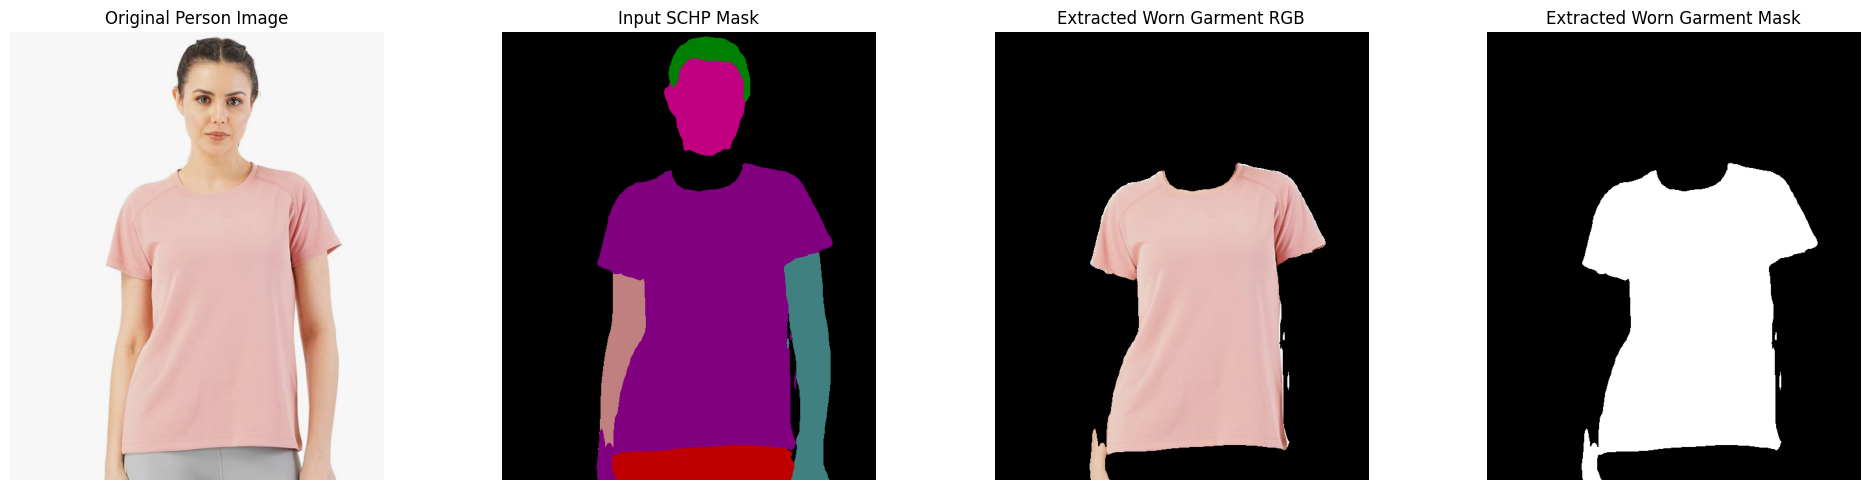

In [27]:
input_original_image_path = "/content/Inputs/target-person.jpg"
input_schp_mask_path = "/content/Inputs/target.png"
output_dir = "/content/Outputs/worn_garment"

# Load original input images
original_person_image = Image.open(input_original_image_path)
original_schp_mask = Image.open(input_schp_mask_path)

# Load processed garment RGB and mask
processed_worn_garment_rgb = Image.open(os.path.join(output_dir, "garment_rgb.png"))
processed_worn_garment_mask = Image.open(os.path.join(output_dir, "garment_mask.png"))

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(original_person_image)
plt.title("Original Person Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(original_schp_mask, cmap='jet')
plt.title("Input SCHP Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(processed_worn_garment_rgb)
plt.title("Extracted Worn Garment RGB")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(processed_worn_garment_mask, cmap='gray')
plt.title("Extracted Worn Garment Mask")
plt.axis("off")

plt.tight_layout()
plt.show()